# An Attempt to Predict Future Asset Price Change
(This notebook is created by [liyinnbw](https://github.com/liyinnbw/ML/tree/master/PriceChangePrediction) under the MIT license)

Problem Definition:

* Given a time series of past N days of an asset's trading data (including price, volume, etc.) predict the average price change in next M days.

## Load Data
The sample data is 20 year daily trading data of the PowerShares QQQ Trust

In [15]:
import pandas as pd
import numpy as np

df_o = pd.read_csv('https://raw.githubusercontent.com/liyinnbw/ML/master/PriceChangePrediction/daily_QQQ.csv')
df = df_o.sort_values(['timestamp'])
df = df.reset_index(drop=True)
df

,timestamp,open,high,low,close,volume
0,2000-02-03,188.60,193.300,184.6000,193.00,15289900
1,2000-02-04,194.00,196.500,192.4000,194.30,13320000
2,2000-02-07,194.50,197.300,192.5000,197.00,8880500
3,2000-02-08,198.80,205.800,198.8000,205.30,10999700
4,2000-02-09,204.10,204.400,197.5000,198.00,13629100
...,...,...,...,...,...,...
5027,2020-01-29,222.66,222.930,220.8300,221.81,29063128
5028,2020-01-30,220.37,222.700,219.6891,222.60,39568093
5029,2020-01-31,223.50,223.560,218.2850,219.07,52015832
5030,2020-02-03,220.14,222.885,219.9900,222.38,25468307


## Compute Daily Fractional Changes


In [3]:
df_processed = pd.DataFrame()
df_processed[['daily_price_change', 'daily_volume_change']] = df[['close', 'volume']].pct_change()

pred_days = 5
df_processed['average_price_change_in_next_{}_days'.format(pred_days)] = df['close'].rolling(window=pred_days).mean().shift(-pred_days)/df['close']-1
df_processed = df_processed.dropna()
df_processed

,daily_price_change,daily_volume_change,average_price_change_in_next_5_days
1,0.006736,-0.128837,0.034071
2,0.013896,-0.333296,0.022437
3,0.042132,0.238635,-0.023186
4,-0.035558,0.239043,0.014848
5,0.032828,-0.033627,-0.017604
...,...,...,...
5022,0.002642,-0.003709,-0.009559
5023,0.003216,0.277758,-0.014506
5024,-0.008415,0.412905,-0.009403
5025,-0.020656,0.128963,0.015415


## Prepare Features & Labels
* Input feature (x): N days history of features up till today (dimension: ?, N, 2)
* Output label (y): The next day close price change from today (dimension: ?, 1)

In [13]:
history_days = 20

features = df_processed.iloc[:, :-1].values 
x = np.array([features[i:i+history_days] for i in range(0, len(features)-history_days+1)])
y = df_processed.iloc[:,-1].values[history_days-1:].reshape(-1,1)

# print(x)
# print(y)
print(x.shape, y.shape)
print('fraction of samples with positive price change in future = {}'.format(len(np.where(y>0)[0])/len(y)))

(5007, 20, 2) (5007, 1)
fraction of samples with positive price movement = 0.5562212901937288


## Check Label Distribution

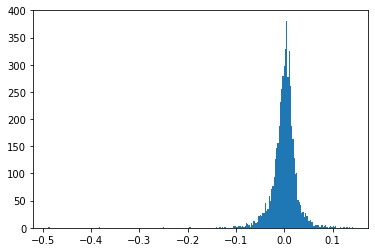

In [5]:
import matplotlib.pyplot as plt

_ = plt.hist(y, bins='auto')

## Prepare Training and Testing data
Because stock has bear and bull markets, we should sample randomly from the full data to get test samples. Otherwise, the test result may not be representative enough.

In [6]:
import numpy as np

totalsamples = x.shape[0]
testsamples = 300
idxs = np.arange(totalsamples)
np.random.shuffle(idxs)

x_train = x[idxs][:-testsamples]
y_train = y[idxs][:-testsamples]
x_test = x[idxs][-testsamples:]
y_test = y[idxs][-testsamples:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4707, 20, 2) (4707, 1)
(300, 20, 2) (300, 1)


## NetGenerator

In [7]:
import tensorflow as tf
from keras import optimizers

class NetGenerator():
  def __init__(self, input_shape, out_size):
    self.input_shape = input_shape
    self.out_size = out_size

  def next(self):

    modelnames =[
      'lstm-20day-history',
    ]
     
    for idx, name in enumerate(modelnames):
      
      model = None
      inputs = keras.Input(shape=self.input_shape)
    #   x = keras.layers.Conv1D(filters=20, kernel_size=3, strides=1,padding='same')(inputs)
    #   x = keras.layers.BatchNormalization()(x)
    #   x = keras.layers.Activation('relu')(x)

      x = keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(inputs)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)(x)
      x = keras.layers.BatchNormalization()(x)

      x = keras.layers.Dense(self.out_size)(x)
      x = keras.layers.Activation('tanh')(x)
      model = keras.Model(inputs=inputs, outputs=x)
      model.compile(
          loss='mean_squared_error',
          optimizer=optimizers.Adam(lr=0.001)
      )

      yield (name, model)


Using TensorFlow backend.


## Training
Uncomment the following for training stats visualization when using colab.

In [0]:
# !pip install tensorboardcolab
# from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

# tbc=TensorBoardColab(port=6007, graph_path='.', startup_waiting_time=8)

In [9]:
import keras
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend as K 
import tensorflow as tf

print (keras.__version__)
print (tf.__version__)

net_gen = NetGenerator(
    input_shape=x_train[0].shape, 
    out_size=y_train[0].shape[0], 
)

# very important or error
K.clear_session()
net_generator = net_gen.next()
modelconfig=next(net_generator,None)
  
while modelconfig!=None:

    modelname,model = modelconfig

    print(modelname)
    model.summary()

    cb_tensorboard = TensorBoard(
        log_dir='./log/'+modelname,
        histogram_freq=100,  
        write_graph=True, 
        write_images=False,
        write_grads=False
    )

    cb_checkpoint = ModelCheckpoint(
        './log/'+modelname+'_weights.h5', 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True, 
        mode='auto', 
        period=1
    )

    model.fit(
        x=x_train, 
        y=y_train, 
        batch_size=256, 
        epochs=200, 
        verbose=1, 
        callbacks=[cb_tensorboard, cb_checkpoint], 
        validation_split=0.1, 
        shuffle=True, 
        initial_epoch=0, 
        steps_per_epoch=None, 
        validation_steps=None
    )
    
    # very important or error
    K.clear_session()
    modelconfig=next(net_generator,None)

print('All done')

2.2.5
1.15.0





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

lstm-20day-history
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 2)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 64)            17152     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 64)            256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)

## Testing
* If the prediction is correct, the dots should form 45 degree diagonal line(y_pred = y_test).
* If the prediction sign is correct, the dots should be in first or third quadrant.

fraction of test cases with positive price change in future = 0.5666666666666667
predicted price movement direction accuracy = 0.4766666666666667


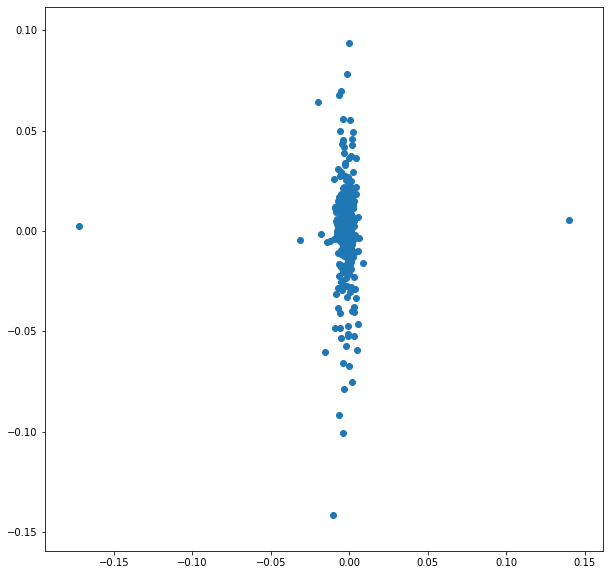

In [14]:
import matplotlib.pyplot as plt

K.clear_session()
net_generator = net_gen.next()
modelconfig=next(net_generator,None)
modelname,model = modelconfig
model.load_weights('log/'+modelname+'_weights.h5')

x_eval = x_test
y_eval = y_test


y_pred = model.predict(x_eval)

plt.figure(figsize=(10,10))
plt.scatter(y_pred.reshape(-1), y_eval.reshape(-1) )
# plt.plot(range(y_pred.shape[0]),y_pred[:,0],color='blue')
# plt.plot(range(y_eval.shape[0]),y_eval[:,0],color='deepskyblue')

print('fraction of test cases with positive price change in future = {}'.format(len(np.where(y_eval>0)[0])/len(y_eval)))
print('predicted price movement direction accuracy = {}'.format(len(np.where(np.multiply(y_eval,y_pred)>0)[0])/len(y_eval)))

## Conclusion
* The model could not predict price change in future (see graph above).
* This may be logical as someone conjured that stock price as "a random walk".
* You may try a different history window or use a different model.